## This merges RTP log data (time, temperature, voltage) with XRD data (time from image header)

### Define paths etc

In [1]:
rtp_temperature = 'Temperature - TC 1' # Name of column in RTP file that holds the temperature
rtp_time = 'Time - Set T'
rtp_voltage = 'Temperature - Volt'
rtp_setT = 'Temperature - Set T'
rtp_BLV = 'Temperature - BL V'
rtp_csv_path = r'F:\beamlinedata\Hypo\Laura_SbN_RTP\heatingramps\Sb3.csv'
# rtp_csv_path = r'F:\beamlinedata\Hypo\Laura_SbN_RTP\heatingramps\01999-r1c1.csv'
image_path = r'F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s'
# to synchronize the time stamps: the time at which "threshold_col > threshold" is taken to be simultaneous with the time of the first image
threshold_col = 'BLV' 
threshold = 3.
output_path = r'F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_T.csv'

### Import and define functions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import fabio
import datetime
    

def get_col_from_rtp(df, colname):
    i = 0
    colname = colname.lower()
    while (colname not in str(df.columns.values[i]).lower()) and (i < len(df.columns.values)): 
        i+=1
    return df[df.columns.values[i]]

def fix_hour(c):
    """
    RTP time has only min, seconds and ms, no hours, so if the experiments goes across one hour, the time appears to go backwards
    this function adds 1 to the hours in that case
    """
    for i in np.arange(len(c)-1)+1:
        if int(c[i][:2]) < int(c[i-1][:2]): 
            c[i:] = '01:' + c[i:]
            c[:i] = '00:' + c[:i]
            return c
    c[:] = '00:' + c[:]
    return c

def time_from_pilheader(header):
    """
    extracts time from pilatus header
    """
    timestring = str(header['date'].split(' ')[-1]).rstrip('\0')
    return datetime.datetime.strptime(timestring, '%H:%M:%S')

def get_image_time(imagename):
    header = fabio.open(os.path.join(image_path, imagename)).header
    return time_from_pilheader(header)  

C:\Anaconda2\envs\py2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Read RTP csv file into database


,temperature,setT,BLV
time,,,
1900-01-01 00:41:58.800,27.1996,15.0,0.003008
1900-01-01 00:41:58.800,27.2648,15.0,0.002684
1900-01-01 00:41:59.000,27.4092,15.0,0.003008
1900-01-01 00:41:59.000,27.2359,15.0,0.002036
1900-01-01 00:41:59.100,27.3308,15.0,0.003333


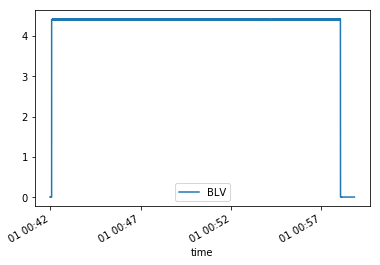

In [3]:
rtp_df = pd.read_csv(rtp_csv_path)
rtp_df2 = pd.DataFrame()
rtp_df2['time'] = get_col_from_rtp(rtp_df, rtp_time)
rtp_df2['temperature'] = get_col_from_rtp(rtp_df, rtp_temperature).astype(float)
rtp_df2['setT'] = get_col_from_rtp(rtp_df, rtp_setT).astype(float)
rtp_df2['BLV'] = get_col_from_rtp(rtp_df, rtp_BLV).astype(float)
rtp_df2['time'] = fix_hour(np.array(rtp_df2['time']))
rtp_df2.time = pd.to_datetime(rtp_df2['time'], format='%H:%M:%S.%f')
rtp_df2 = rtp_df2.set_index('time')
rtp_df2.plot(y='BLV')
rtp_df2.head()


### Determine time at which trigger signal comes in

In [4]:
rtp_steptime = np.argmax(rtp_df2[threshold_col] > threshold) # when df is indexed with time, argmax returns time and not element number
print 'RTP time when trigger turned on (images started acquiring): ', rtp_steptime

RTP time when trigger turned on (images started acquiring):  1900-01-01 00:42:04.100000


C:\Anaconda2\envs\py2\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


### Read images into database

In [5]:
image_files = glob.glob(os.path.join(image_path, '*.tif*'))
images_df = pd.DataFrame(image_files, columns=['imagename'])
images_df['image_basename'] = images_df.imagename.apply(os.path.basename)
images_df['image_time'] = images_df.imagename.apply(get_image_time)
images_df = images_df.set_index('image_time')
images_df.head()


,imagename,image_basename
image_time,,
1900-01-01 14:28:15,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00000.tiff
1900-01-01 14:28:16,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00001.tiff
1900-01-01 14:28:17,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00002.tiff
1900-01-01 14:28:18,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00003.tiff
1900-01-01 14:28:19,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00004.tiff


### Determine time offset between RTP log file and images

In [6]:
print 'time of first image acc. to header: ', images_df.index.values[0]
print 'RTP time when trigger turned on (images started acquiring): ', rtp_steptime
time_offset = rtp_steptime - images_df.index.values[0]
print 'time offset: ', time_offset

time of first image acc. to header:  1900-01-01T14:28:15.000000000
RTP time when trigger turned on (images started acquiring):  1900-01-01 00:42:04.100000
time offset:  -1 days +10:13:49.100000


### Add RTP time column to image database

In [7]:
images_df['RTP_time'] = images_df.index + time_offset
images_df.head()

,imagename,image_basename,RTP_time
image_time,,,
1900-01-01 14:28:15,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00000.tiff,1900-01-01 00:42:04.100
1900-01-01 14:28:16,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00001.tiff,1900-01-01 00:42:05.100
1900-01-01 14:28:17,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00002.tiff,1900-01-01 00:42:06.100
1900-01-01 14:28:18,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00003.tiff,1900-01-01 00:42:07.100
1900-01-01 14:28:19,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00004.tiff,1900-01-01 00:42:08.100


### Merge RTP database and image database

In [8]:
df = images_df.join(rtp_df2, on='RTP_time')
df.head()

,imagename,image_basename,RTP_time,temperature,setT,BLV
image_time,,,,,,
1900-01-01 14:28:15,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00000.tiff,1900-01-01 00:42:04.100,27.2144,16.5000,4.40545
1900-01-01 14:28:16,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00001.tiff,1900-01-01 00:42:05.100,27.4131,31.0638,4.39443
1900-01-01 14:28:17,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00002.tiff,1900-01-01 00:42:06.100,27.3957,41.7021,4.39670
1900-01-01 14:28:18,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00003.tiff,1900-01-01 00:42:07.100,27.6693,52.3404,4.39929
1900-01-01 14:28:19,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00004.tiff,1900-01-01 00:42:08.100,32.7623,62.9787,4.39540


### Add column for relative time

In [9]:
df.insert(0, 'time relative in s', df.RTP_time.apply(lambda x: x-df.RTP_time[0]))
df['time relative in s'] = df['time relative in s'].apply(lambda x: x.seconds)
df.head()

,time relative in s,imagename,image_basename,RTP_time,temperature,setT,BLV
image_time,,,,,,,
1900-01-01 14:28:15,0,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00000.tiff,1900-01-01 00:42:04.100,27.2144,16.5000,4.40545
1900-01-01 14:28:16,1,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00001.tiff,1900-01-01 00:42:05.100,27.4131,31.0638,4.39443
1900-01-01 14:28:17,2,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00002.tiff,1900-01-01 00:42:06.100,27.3957,41.7021,4.39670
1900-01-01 14:28:18,3,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00003.tiff,1900-01-01 00:42:07.100,27.6693,52.3404,4.39929
1900-01-01 14:28:19,4,F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_500_60s...,Sb_01915_3_500c_1m_144344_00004.tiff,1900-01-01 00:42:08.100,32.7623,62.9787,4.39540


### Write to csv

In [10]:
df.to_csv(output_path)
print 'file written to ', output_path

file written to  F:\beamlinedata\Hypo\Laura_SbN_RTP\Sb3_T.csv
